In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.patches as patches

In [2]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.models import Sequential
from keras.utils import np_utils 
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


### 6 - Bonus Question

In [3]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


In [4]:
'''
Modification of previous functions.
Generate_two_* now generates 2 figures, one with a noise between [10, rand_max+10==60], and the same figure without noise.
The figures generated are centered, it will need less computer power to fit a good model
'''

def generate_two_rectangle(rand_min=30, rand_max=100):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    corners = np.random.random(4)
    side = (0.3 + 0.7 * np.random.random()) * figsize
    top = figsize/2 + side/2
    bottom = figsize/2 - side/2
    left = bottom
    right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    
    noise = np.random.randint(rand_min, rand_max)
    X = generate_a_drawing(figsize, U, V, noise)
    Y = generate_a_drawing(figsize, U, V, noise=0)
    return [X, Y]

def generate_two_disk(rand_min=30, rand_max=100):
    figsize = 1.0
    center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
        
    noise = np.random.randint(rand_min, rand_max)
    X = generate_a_drawing(figsize, U, V, noise)
    Y = generate_a_drawing(figsize, U, V, noise=0)
    return [X, Y]

def generate_two_triangle(rand_min=30, rand_max=100):
    figsize = 1.0
    size = (0.3 + 0.7 * np.random.random())*figsize/2
    middle = figsize/2
    U = (middle, middle+size, middle-size)
    V = (middle+size, middle-size, middle-size)

    noise = np.random.randint(rand_min, rand_max)
    X = generate_a_drawing(figsize, U, V, noise)
    Y = generate_a_drawing(figsize, U, V, noise=0)
    return [X, Y]

def generate_double_dataset(nb_samples):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 200 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            [X[i], Y[i]] = generate_two_rectangle()
        elif category == 1: 
            [X[i], Y[i]] = generate_two_disk()
        else:
            [X[i], Y[i]] = generate_two_triangle()
    print('Done!')
    return [X, Y]

In [5]:
'''
Plot some figures to check the model
'''

def verif_bonus(figure=np.random.randint(3)):
    
    if figure == 0:
        [X, Y] = generate_two_rectangle()
    if figure == 1:
        [X, Y] = generate_two_disk()
    if figure == 2:
        [X, Y] = generate_two_triangle()
        
    X = X.reshape(1,72,72,1)
    prediction = model.predict(X)

    plt.figure(figsize=(6,6))
    plt.subplot(1,3,1)
    plt.imshow(X.reshape(72,72), cmap='gray')
    plt.title('Original')
    plt.subplot(1,3,2)
    plt.imshow(Y.reshape(72,72), cmap='gray')
    plt.title('Cleaned')
    plt.subplot(1,3,3)
    plt.imshow(prediction.reshape(72,72), cmap='gray')
    plt.title('Prediction')
    plt.show()

In [6]:
'''
Creation of the dataset
'''
size_dataset = 1000
[X, Y] = generate_double_dataset(size_dataset)
X = X.reshape(-1,72,72,1)

Creating data:
0
200
400
600
800
Done!


In [7]:
model = Sequential()

model.add(Conv2D(filters=72, kernel_size=(3,3), activation='relu', input_shape=(72,72,1)))
model.add(Conv2D(filters=72, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=36, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=36, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=72, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=72, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(5184, activation='relu'))

model.compile(loss='mean_squared_error', optimizer='adam')

In [8]:
fitted_model = model.fit(X, Y, batch_size=50, epochs=50, verbose=1)

Epoch 1/50
1000/1000 [==============================] - 52s 52ms/step - loss: 16840.1896

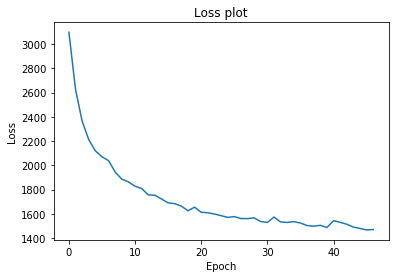

In [18]:
plt.plot(fitted_model.history['loss'][3:])
plt.title('Loss plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

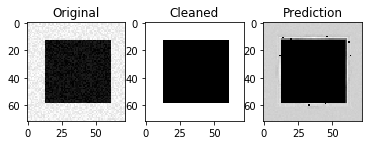

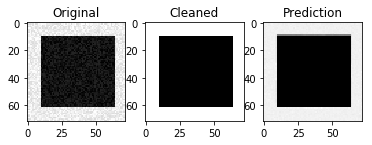

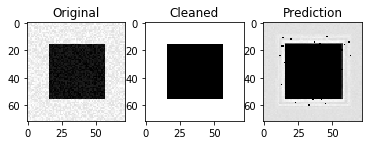

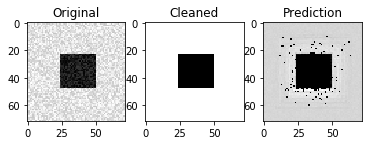

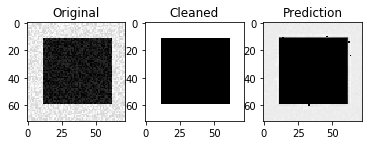

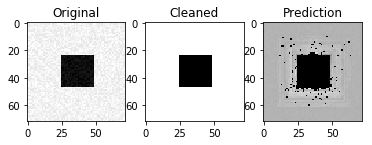

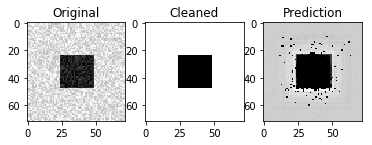

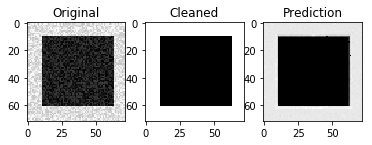

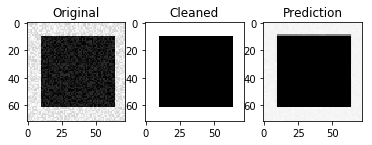

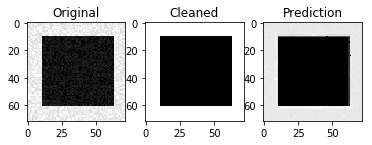

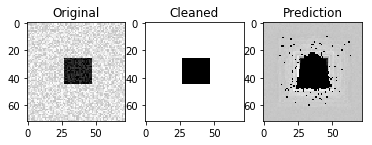

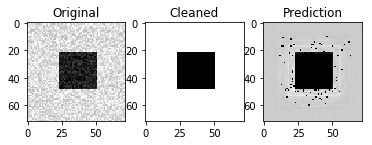

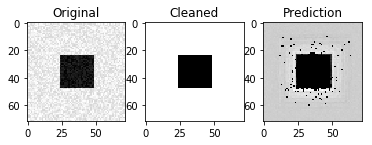

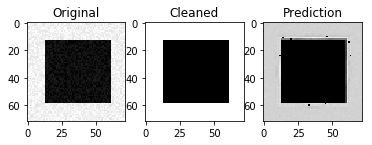

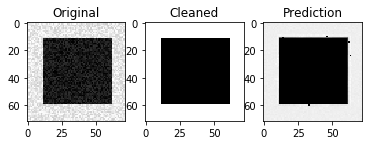

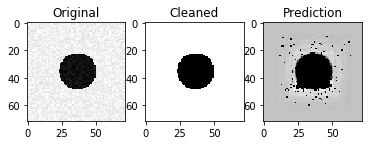

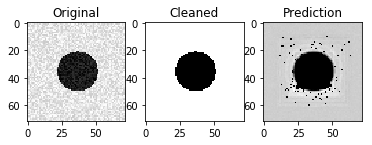

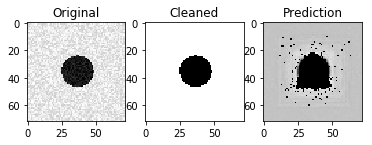

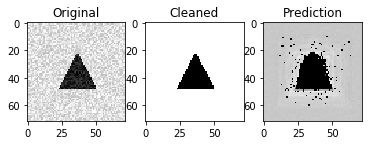

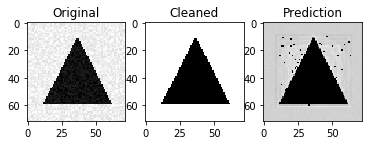

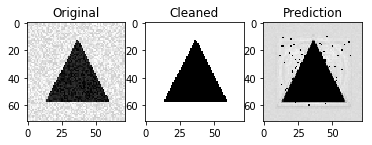

In [20]:
for i in range(15):
    verif_bonus(0)
for i in range(3):
    verif_bonus(1)
for i in range(3):
    verif_bonus(2)